# Table of Contents
* [Monitoring the composites ($N_c$) for higher frequency deviations](#Monitoring-the-composites-%28$N_c$%29-for-higher-frequency-deviations)
	* [Load the data](#Load-the-data)
	* [Long-term error](#Long-term-error)
	* [Phase I SPC: Estimation of the regular patterns](#Phase-I-SPC:-Estimation-of-the-regular-patterns)
		* [Selection of the pool of stable stations](#Selection-of-the-pool-of-stable-stations)
		* [Standardisation](#Standardisation)
		* [Histogram of the standardised data](#Histogram-of-the-standardised-data)
	* [Phase II SPC: Monitoring](#Phase-II-SPC:-Monitoring)
		* [Choice of the block length](#Choice-of-the-block-length)
		* [Choice of the target shift size](#Choice-of-the-target-shift-size)
		* [Control limit of the chart.](#Control-limit-of-the-chart.)
	* [Phase III: Estimation of shift sizes and shapes using SVMs](#Phase-III:-Estimation-of-shift-sizes-and-shapes-using-SVMs)
		* [Control limit without missing values](#Control-limit-without-missing-values)
		* [Selection of the length of the input vector](#Selection-of-the-length-of-the-input-vector)
		* [Choice of the regularization parameter](#Choice-of-the-regularization-parameter)
		* [Training and validation of the SVMs](#Training-and-validation-of-the-SVMs)
	* [Monitoring and results display](#Monitoring-and-results-display)


#  Monitoring the composites ($N_c$) for higher frequency deviations

In [1]:
import pickle
import numpy as np 
import pkg_resources as pkg
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6.0)
import warnings
warnings.simplefilter('ignore')
import sys
sys.path.insert(1, '../Sunspot/')
sys.path.insert(2, '../../')

from SunSpot import errors as err
from SunSpot import preprocessing as pre
from SunSpot import cusum_design_bb as chart
from SunSpot import alerts as plot
from SunSpot import svm_training as svm
from SunSpot import autocorrelations as bbl

## Load the data

In [2]:
### load data (loaded automatically with package)
#data_path = pkg.resource_filename(pkg.Requirement.parse("SunSpot"), 'data')

#with open(data_path + '\data_1981', 'rb') as file: 
with open('../../data/data_1981', 'rb') as file: #local
    my_depickler = pickle.Unpickler(file)
    Ns = my_depickler.load() #number of spots
    Ng = my_depickler.load() #number of sunspot groups
    Nc = my_depickler.load() #composite: Ns+10Ng
    station_names = my_depickler.load() #index of the stations
    time = my_depickler.load() #time
    
### add new data to station KS (those are not included in database)
#data_ks = np.loadtxt(data_path +'\kisl_wolf.txt', usecols=(0,1,2,3), skiprows=1)
data_ks = np.loadtxt('../../data/kisl_wolf.txt', usecols=(0,1,2,3), skiprows=1) #local
Nc_ks = data_ks[9670:23914,3]
Nc[:,24] = Nc_ks

## Long-term error

The first step of the monitoring is to compute the long-term error, which accounts for systematic bias of the stations.  <br>
This error may be estimated by the following equation:
$$ \hat \mu_2(i,t) = \left( \frac{ Y_i(t)}{M_t} \right)^\star ~ \ \text{when} \ M_t>0 $$
where 
- the $\star$ denotes the smoothing process by a moving average (MA) ;
- $Y_i(t)$ are the raw observations (counts) in station $i$ at time $t$ ; 
- $M_t=\underset{1 \leq i\leq N}{\text{med}} Z_i(t)$ is the median of the network ; 
- $Zi(t)$ are the rescaled data, defined as $ Z_i(t) = \frac{Y_i(t)}{\kappa_i(t)} $ ;  
-  $\kappa_i(t)$ are the piece-wise constant scaling-factors, calculated using the ordinary least-squares regression (OLS) of the observations on the median of the network. <br>

As explained in <a id="ref-1" href="#cite-Mathieu2019">(Mathieu 2019, section 4)</a>, the duration of the period where the scaling-factors are assumed to be constant may be selected by a statistical-driven study based on the Kruskal-Wallis test <a id="ref-2" href="#cite-Kruskal_Wallis">(Kruskal & Wallis 1952)</a>. This test shows that the minimal time-scale is equal to 10 months for Nc, 8 months for Ns and 14 months for Ng. <br>
The scaling-factors may thus be computed on periods of 10 months. Afterwards, the data may be rescaled by these factors and the median of the network, $M_t$, may be evaluated on the rescaled observations. <br>
After dividing the observations by $M_t$, we also smooth the ratio by a moving average (MA) of length larger than or equal to 27 days to remove the influence of the short-term ($\epsilon_1$). Here, we choose a length equal to 27 days to better highlight the jumps.
Whereas a longer scale such as 1 or 2 years may be selected to highlight the drifts. <br>

The function `long_term_error()`, which computes the long-term error, contains the main following parameters (for more info look directly at the documentation on top of the function): 
- `data` : the raw observations (here Nc) 
- `period_rescaling` : period where the scaling-factors are assumed to be constant, expressed in months (10 months are selected here).
- `wdw` : the length of the MA, expressed in days (27 days are selected here)


In [3]:
mu2 = err.long_term_error(Nc, period_rescaling=10, wdw=27)

#discard stations with no values
ind_nan = []
for i in range(mu2.shape[1]):
   if not np.all(np.isnan(mu2[:,i])): 
       ind_nan.append(i)
mu2 = mu2[:,ind_nan]
station_names = [station_names[i] for i in range(len(station_names)) if i in ind_nan]
(n_obs, n_series) = mu2.shape

The long-term errors have different levels in each station, due to differences of instruments or counting methodology. <br>
Therefore, we first remove these levels (which correspond to the 'k' factors) from the long-term errors, since we are not interested in monitoring these differences. To identify the levels, we assume that they live on a longer scale than the errors (smoothed on 27 days). <br>
Hence, we remove the levels by subtracting a moving average of length equal to eleven years (or one solar cycle) from the errors, a physical scale of the data that is larger than 27 days. <br>
To this end, we call the function `level_removal()` from the file `preprocessing`, with a window length `wdw` equal to approximately eleven years. 

In [4]:
### Apply preprocessing
dataNs = pre.PreProcessing(mu2) #the preprocessing in encapsulated in a class!

### Remove intrisic levels from the series
dataNs.level_removal(wdw=4000) #4000 days ~ eleven years 

<!-- https://stackoverflow.com/questions/30061902/how-to-handle-citations-in-ipython-notebook -->
We can now apply the monitoring procedure on the long-term errors without levels. <br>
The statistical process control (SPC) that we used is based on <a id="ref-3" href="#cite-Qiu2014">(Qiu 2014)</a>. It is composed of two phases. 
In the first phase, the regular patterns, i.e. the mean and the variance of the data, are estimated on a subset of stable or in-control (IC) stations, often called 'pool' in the following. Then, the observations of all stations are standardised by these parameters. In the second phase, a CUSUM chart <a id="ref-4" href="#cite-Page1961">(Page 1961)</a> is applied on the standardised observations for the quality control. <br>
A support vector machine classifier and regressor <a id="ref-5" href="#cite-Cheng2011">(Cheng 2011)</a> are also trained and validated on simulated data to allow the prediction of the size and the shape of the shifts after each alert.

## Phase I SPC: Estimation of the regular patterns

### Selection of the pool of stable stations 

First, a subset (also called 'pool' in the following) of in-control (IC) or stable series is selected from the network. To this end, a robust version of the MSE is computed for each series with the function `selection_pool()` from the file `preprocessing`. The series are then clustered in two groups based on their MSE value with the k-means algorithm <a id="ref-6" href="#cite-Lloyd1957">(Lloyd 1957)</a> and the subset with the lowest values is selected as the IC group.

In [5]:
### Selection of the IC pool 
dataNs.selection_pools(method='kmeans')
pool = np.array(dataNs.pool) #pool (number)
pool_ind = [station_names[i] for i in range(n_series) if i in pool] #pool (index)
print('n_pool: ', len(pool))
print(pool_ind)

n_pool:  100
['AN', 'AT', 'CA', 'CR', 'DS', 'FU', 'GE', 'HU', 'KA', 'KH', 'KO', 'KZ', 'LK', 'MC', 'SA', 'YV', 'NY', 'PK', 'AL', 'CU', 'DU', 'EF', 'GU', 'NZ', 'BI', 'DM', 'SL', 'TY', 'VE', 'CQ', 'JJ', 'JR', 'AF', 'AU', 'CH', 'EV', 'RS', 'ST', 'AP', 'AS', 'GP', 'LS', 'OV', 'VD', 'FC', 'MS', 'SP', 'DR', 'JO', 'MB', 'TS', 'VB', 'CT', 'JB', 'PL', 'AE', 'HP', 'ML', 'OA', 'SN', 'TE', 'AO', 'FV', 'PR', 'VK', 'GA', 'OH', 'JP', 'GY', 'JD', 'HT', 'JS', 'LM', 'TH', 'CK', 'GB', 'JC', 'JY', 'VN', 'FD', 'BT', 'BW', 'HL', 'ME', 'SI', 'YT', 'BV', 'DV', 'RI', 'RP', 'VL', 'JM', 'JV', 'AI', 'VJ', 'DP', 'VU', 'LI', 'MJ', 'DT']


Since we expect that the stable stations may also suffer from several important deviations (however less numerous and/or smaller than those of the unstable or out-of-control (OC) series), we also remove the daily outliers of the pool. 
The function `outliers_removal()` removes each day the IC observations that do not fall into one standard deviation (`k=1`) about the mean of the network. 

In [6]:
#remove outliers that do not fall into one standard deviation (k=1) about the mean of the network
dataNs.outliers_removal(k=1) 

### Standardisation

Then, the data (IC and OC) are standardised by time-varying mean and variance. These quantities are computed across the pool of IC stations and along the time using K nearest neighbors (K-NN) regression estimators. Hence, the mean and the variance are always computed on the same number of values (= $K$) even if the data contain missing values. <br>

To this end, we first select the value of $K$ with the function `choice_K()` to obtain the 'best' standardisation of the complete panel, in the sense that its empirical mean becomes close to zero and its empirical variance close to one. This function computes the mean and standard deviation (std) of the standardised data for different values of $K$. Usually, the mean and std exhibit a similar behaviour: the mean comes closer to zero and the std draws near one with increasing values of $K$, as can be seen below. $K$ is thus selected as the knee of the std curve. <br>
The function ``choice_K()`` has several arguments: 
- ``data`` : the data from the whole panel 
- ``data_IC`` : the data from the IC pool only
- ``start`` : starting value for $K$ 
- ``stop`` : stopping value for $K$
- ``step`` : step value for $K$ <br>
The different values of $K$ are thus contained in the range [``start``, ``stop``] with a certain ``step``. <br>

Finally, the data from the whole panel (IC and OC) are standardised by the IC mean and variance using the function ``standardisation()``. This function has a single mandatory arguments: 
 
- ``K`` : the number of nearest neighbours.

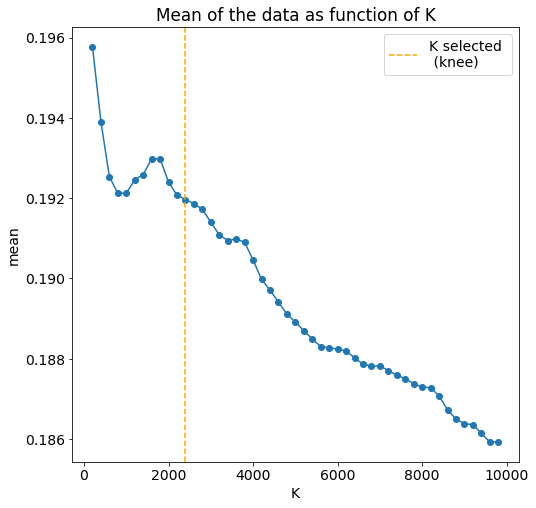

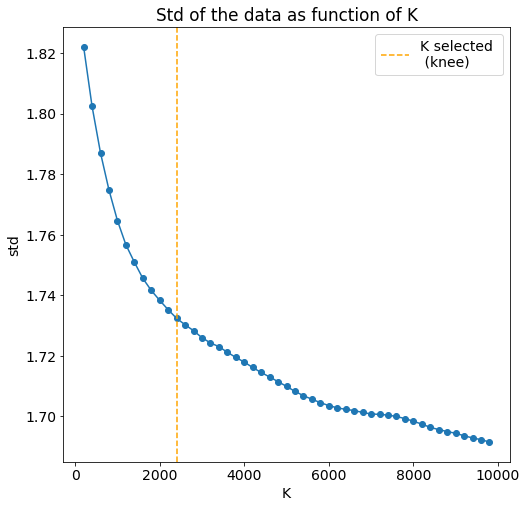

K =  2400
n_days =  24.0
n_obs_IC: 34.49884199002033


In [7]:
### Choice of K 
dataIC = dataNs.dataIC  #IC data without deviations
data = dataNs.data #data (IC and OC) with deviations
K = pre.choice_K(data, dataIC, start=200, stop=10000, step=200)
print('K = ', K)
print('n_days = ', K/len(pool))
dataNs.standardisation(K) #standardisation of the data

dataIC = dataNs.dataIC  #IC data without deviations
data = dataNs.data #data (IC and OC) with deviations
n_obs_IC = len(dataIC[~np.isnan(dataIC)])*100 / len(data[~np.isnan(data)])
print('n_obs_IC:', n_obs_IC)

Or directyl load preprocessed data 

In [8]:
#with open('../data/Nc_27', 'rb') as fichier:
#     my_depickler = pickle.Unpickler(fichier)
#     data = my_depickler.load() #contain all deviations, even from IC stations
#     time = my_depickler.load() #time
#     station_names = my_depickler.load() #code names of the stations
#     dataIC = my_depickler.load() #IC data without deviations
#     pool = my_depickler.load() #pool of IC series
#     mu2 = my_depickler.load() #data with intrinsic levels

(n_obs, n_series) = data.shape #dimensions 

### Histogram of the standardised data

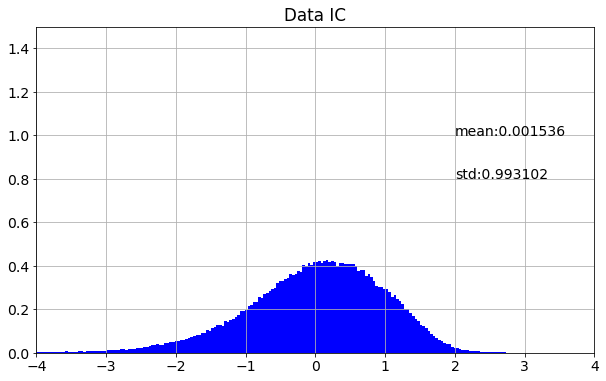

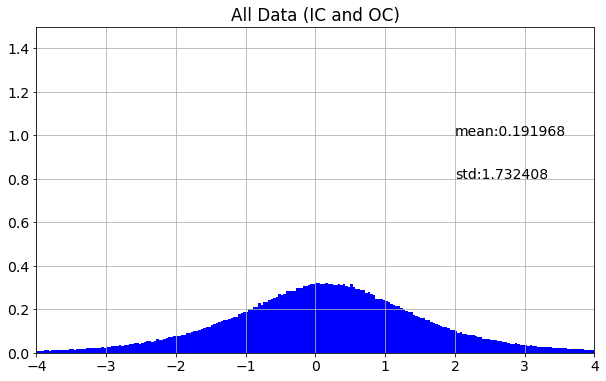

In [9]:
#plot the (IC) data
plt.rcParams['figure.figsize'] = (10.0, 6.0)
plt.hist(dataIC[~np.isnan(dataIC)], range=[-4,4], bins='auto', density=True, facecolor='b')  
plt.title("Data IC")
plt.text(2, 1, 'mean:' '%4f' %np.nanmean(dataIC))
plt.text(2, 0.8, 'std:' '%4f' %np.nanstd(dataIC))
plt.axis([-4, 4, 0, 1.5])
plt.grid(True)
plt.show()

#plot all data
plt.hist(data[~np.isnan(data)], range=[-4,4], bins='auto', density=True, facecolor='b')  
plt.title("All Data (IC and OC)")
plt.text(2, 1, 'mean:' '%4f' %np.nanmean(data))
plt.text(2, 0.8, 'std:' '%4f' %np.nanstd(data))
plt.axis([-4, 4, 0, 1.5])
plt.grid(True)
plt.show()

## Phase II SPC: Monitoring

Having selected an IC pool and standardised the data by the IC mean and variance, we can now move on to the second phase of the method.
In this stage, we calibrate the CUSUM chart on the data using the block bootstrap (BB), a procedure that randomly samples blocks of observations with repetitions from the data to generate new series similar to the observations.

### Choice of the block length

To calibrate the CUSUM chart, we first select an appropriate value for the block length. This length depends on the autocorrelation of the data and can be automatically selected using the function ``block_length_choice()``.
Large blocks usually better model the autocorrelation of the data but at the same time do not represent well the variance and the mean of the series. And conversely. Therefore, we compute an appropriate value for the block length by the following procedure. <br>
For each block length tested, we resample several series of observations using a block bootstrap procedure. Then, the mean squared error (mse) of the mean, standard deviation and autocorrelation are computed on
the resampled series (with respect to the original data). The appropriate value for the block length is finally selected as the knee of the autocorrelation curve. <br>
Intuitively, this length corresponds to the first value such that the main part of the autocorrelation of the series is well represented. <br>

The function ``block_length_choice()`` contains the main following arguments (for more info look directly at the documentation on top of the function): 
- ``data`` : the IC data 
- ``bbl_min`` : starting value for the block length 
- ``bbl_max`` : upper value for the block length 
- ``bbl_step`` : step value for the block length <br>
The different values for the block length are thus contained in the range [``bbl_min``, ``bbl_max``] with step value ``bbl_step``.

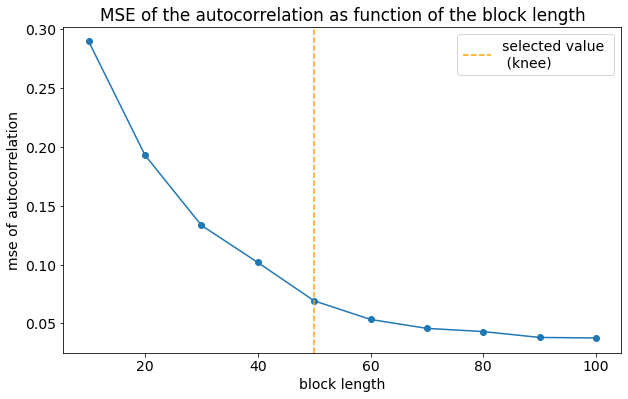

Block length which minimizes the mse of the mean: 10.0
Block length which minimizes the mse of the std: 10.0
Block length which minimizes the mse of the autocorrelation: 100.0


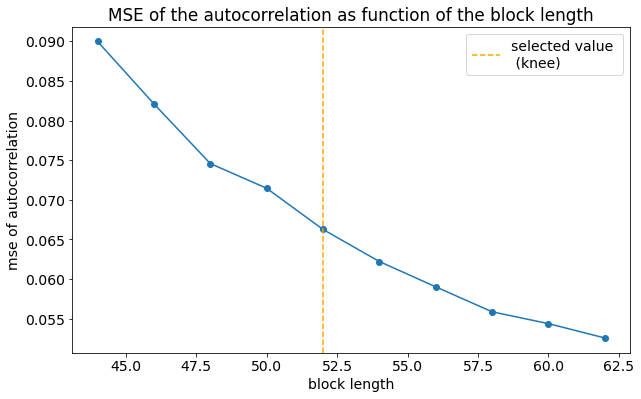

Block length which minimizes the mse of the mean: 54.0
Block length which minimizes the mse of the std: 52.0
Block length which minimizes the mse of the autocorrelation: 62.0
selected block length:  52.0


In [10]:
bb_length = bbl.block_length_choice(data=dataIC, bbl_min=10, bbl_max=110, bbl_step=10)
bb_length = bbl.block_length_choice(data=dataIC, bbl_min=44, bbl_max=64, bbl_step=2)
print('selected block length: ', bb_length)

Since the selected value for the block length is close to 54, a physical scale of the data equal to two solar rotations, we set the block length to 54 in the following. 

In [11]:
bb_length = 54 

### Choice of the target shift size

The target shift size that it is interesting to detect depends on the deviations that the series experience. <br>
This parameter may be estimated recursively with the function ``shift_size()`` as follows. 
For an initial value of the shift size, we compute the control limits of the chart. Then, the chart is applied on out-of-control series and the size of the deviations is estimated after each alert using a classical formula <a id="ref-2" href="#cite-Montgomery2005">(Montgomery 2005)</a>. This formula is only valid for iid normal observations but may however still be used as a first approximation (the real shift sizes will be predicted later using a support vector regressor). 
Then, the value of the shift size is updated such as a specified quantile of the shift sizes distribution. 
The procedure is then iterated until the shift size converges. <br>
Since the shift sizes are expected to variate over a wide range, we select $\delta$ as the 0.5 quantile of the shift sizes distribution (the median). <br>
<br>

The function ``shift_size()`` contains the main following arguments: 
- ``data`` : the data from the whole panel (IC and OC)
- ``pool`` : the index of the IC series in the panel
- `dataIC` : the IC data (without major deviations)
- ``delta`` : the initial value for the target shift size 
- ``ARL0_threshold`` : the pre-specified value of the average run length (ARL0). <br>
This value controls the rate of false positives (the rate of false positivse is inversely proportional to the ARL0). It is set to 200.
- ``block_length`` : the length of the blocks 
- ``qt`` : the quantile of the shift sizes distribution 
- ``missing_values`` : policy to treat the missing values. <br>
The missing values policy is set to `reset`. In this mode, the chart is calculated on data that contain missing observations and is reset at each missing value (chart statistics = 0). 

In [12]:
delta_min = 1 #intial value for the target shift size
ARL0 = 200 #pre-specified ARL0 (controls the false positives rate)

### estimate an appropriate shift size (specified quantile = 0.5)
delta_min = chart.shift_size(data, pool, dataIC=dataIC,
                delta=delta_min, ARL0_threshold=ARL0, block_length=bb_length, 
                qt=0.5, missing_values ='reset')[1]

420.2959776522596
15.0
153.6293370382466
22.5
265.25681491288265
18.75
205.3080144259966
16.875
176.6075311699885
17.8125
190.82757303332735
18.28125
198.3568177956066
18.515625
control limit:  18.515625
shift size:  1.3453888418587432
590.6472651313874
15.0
231.94806391536756
7.5
104.93211578729802
11.25
161.73827717786784
13.125
190.20375367526952
14.0625
206.86012304561143
13.59375
201.53872124656158
13.359375
control limit:  13.359375
shift size:  1.3613917620914697


We obtain a target shift size close to 1.4 that we round to 1.4.

In [13]:
delta_min = 1.4

### Control limit of the chart.

Having selected the block length and the target shift size, the control limits of the CUSUM chart can finally be adjusted on the IC series.
To this end, we use the function ``limit_CUSUM()``, which adjusts the limits in a specified searching interval (the default is [0, 20]) until a pre-specified value for the rate of false positive (ARL0) is reached at the desired accuracy. <br>

The function ``limit_CUSUM()`` contains the main following arguments: 
- ``dataIC`` : the IC data (without major deviations)
- ``delta`` : the target shift size 
- ``ARL0_threshold`` : the pre-specified value of the average run length (ARL0). <br>
This value controls the rate of false positives (the rate of false positivse is inversely proportional to the ARL0). It is set by default to 200.
- ``L_plus`` : the upper value of the searching interval 
- ``block_length`` : the length of the blocks 
- ``missing_values`` : policy to treat the missing values. <br>
The missing values policy is set to `reset`. In this mode, the chart is calculated on data that contain missing observations and is reset at each missing value (chart statistics = 0). 

The function returns the positive value for the control limit. The negative limit has the same value as the positive one with opposite sign since the distribution of the data is (almost) symmetric. 

In [14]:
control_limit = chart.limit_CUSUM(dataIC, delta=delta_min, ARL0_threshold=200, L_plus=20,
                block_length=bb_length, missing_values='reset')

149.10713040158896
15.0
245.91694779922696
12.5
195.09074432922756
13.75
218.78205298081463
13.125
210.0502159175851
12.8125
200.56474845129418
12.65625


For reproduciability purpose, we set the value of the control limit equal to 13, since it varies slightly from one run to another.

In [15]:
control_limit = 13

## Phase III: Estimation of shift sizes and shapes using SVMs

In this third and last phase of the monitoring method, the support vector machines (SVM) for extracting and classifying out-of-control patterns are designed. Those methods are composed of a support vector regressor (SVR) to predict the size of the shifts in a continuous range and a support vector classifier (SVC) to classify the shape of the encountered deviations among a pre-defined number of classes.

### Control limit without missing values 

Previous values for the control limits are computed on data that may contain some missing values. 
However, the support vector machine procedures do not support missing observations (in practice, the missing observations are interpolated for the support vector machine predictions). Therefore, 
the training and the validation are entirely done on simulated data without missing values. 
This might require to readjust the control limits of the chart for data without missing values. This is done by setting the missing value policy  to `omit` in the following function, which entirely supresses the blocks containing a missing observation. 

In [16]:
### compute the control limit of the chart without MVs
control_limit_mv = chart.limit_CUSUM(dataIC, delta=delta_min, ARL0_threshold=ARL0,
              block_length=bb_length, missing_values='omit')

128.241932275435
15.0
191.80963871806193
17.5
225.52033867543472
16.25
205.20695573534007
15.625
195.69446420594537
15.9375
200.8891972977317
15.78125


Those is fixed at 15.5 for reproducibility purpose.

In [17]:
control_limit_mv = 15.5

### Selection of the length of the input vector

The length of the input vector represents the number of past observations that are fed to the support vector classifier and regressor after each alert. The regressor and classifier then predict the form and the size of the shift that causes the alert based on this vector.  
Hence, the length should be sufficiently large to ensure that most of the shifts are contained within the input vector while maintaining the computing efficiency of the method. This is usually not a problem for the large shifts that are quickly detected by the chart. However the smallest shifts may be detected only after a certain amount of time and therefore require large vectors. <br>
Hence, the length is selected as an upper quantile of the run length distribution, computed on data shifted by the smallest shift size that we aim to detect. <br>

To select this length, we can use the function ``input_vector_length()``. It works as follows.  <br>
For each monte-carlo run, a new series of observations is sampled from the IC data using a block bootstrap procedure. Then, a jump of size ``delta_min`` is simulated on top of the sample. The run length of the chart is then evaluated. The length of the input vector is finally selected as a specified upper quantile (quantile >=0.5) of the run length distribution. If the quantile is unspecified, an optimal quantile is selected by locating the 'knee' of the quantiles curve.  <br>

The function ``input_vector_length()`` has the following main arguments: 
- ``data`` : the IC standardised data 
- ``delta_min`` : the target shift size 
- ``L_plus`` : the value of the positive control limit 
- ``block_length`` : the length of the blocks 
- ``qt`` : the specified upper quantile

In [19]:
#import importlib
#importlib.reload(svm)
#from SunSpot import svr_svc_training as svm
plt.rcParams['figure.figsize'] = (10.0, 6.0)
wdw_length = svm.input_vector_length(dataIC, delta_min, L_plus=control_limit_mv, block_length=bb_length)
print('wdw_length: ', wdw_length)

wdw_length:  72


For reproduciability purpose, the length is fixed at 70. 

In [20]:
wdw_length = 70

###  Choice of the regularization parameter

The regularization parameter ($\lambda$) represents the trade-off between misclassification and regularization.
It may be automatically selected with the function ``choice_C()``. 
This function selects $\lambda$ (sometimes called $C$ in the literature) to maximize the performance of the SVM classifier and regressor.
To this end, it trains the classifier and regressor on simulated deviations for different values of $\lambda$ in the range [`` start``, ``stop``] with a certain `` step``.
The function then returns the value of $\lambda$ that maximizes the accuracy for the classifier and those that minimize the mean squared error (MSE) and the mean absolute percentage error (MAPE) for the regressor. <br>

This function contains the main following arguments: 

- ``data`` : the IC standardised data 
- ``L_plus`` : the value of the positive control limit 
- ``delta`` : the target shift size 
- ``wdw_length`` : the length of the input vector 
- ``scale`` : the scale parameter of the half-normal distributions that are used to randomly select the sizes of the artificial deviations. This parameter depends on the actual deviations of the data and should be selected such as the highest deviations are well reproduced. 
- ``start`` : starting value for $\lambda$ 
- ``stop`` : stopping value for $\lambda$ 
- ``step`` : step value for $\lambda$ 
The different values of $\lambda$ are thus contained in the range [``start``, ``stop``] with a certain ``step``. <br>
- ``delay`` : flag to start the monitoring after a random delay in the range [0, ``delay``]
- ``n`` : the number of training and testing instances (4/5 of the instances are used for the training)
- ``block_length`` : the length of the blocks 
- ``confusion`` : flag to print the confusion matrix

In [21]:
scale = 3.5 #scale parameter of the halfnormal distribution

#find an optimal value for C (regularization parameter)
C_choices = svm.choice_C(dataIC, control_limit_mv, delta_min, wdw_length, scale,
                    start = 5, stop = 15, step = 1,
              delay=0, n=12000*3, block_length=bb_length, confusion=False)

C value that minimizes the MAPE: 13
C value that minimizes the MSE: 9
C value that maximizes the accuracy: 12


### Training and validation of the SVMs

Having defined the three main parameters of the SVM procedures, we can now train the classifier and regressor on artificial deviations. 
Those are simulated as follows. After randomly sampling series of IC data by a BB procedure, three types of artificial deviations of size $\delta$ are added top of those series: 

- jumps: $x(t) = x_{ic}(t)+\delta$ ;
- drifts (with varying power-law functions) : $x(t) = x_{ic}(t)+\frac{\delta}{T'}(t)^{a}$, where $a$ is randomly selected in the range $[1.5, 2]$ ;
- oscillating shifts (with different frequencies): $x(t) = x_{ic}(t) \delta \sin{(\eta \pi t)}$, where $\eta$ is randomly selected in the range $[\frac{\pi}{m}, \frac{3\pi}{m}]$. <br>

In practice, the function ``training_svm()`` does both the training and the testing of the classifier and regressor. It has the same arguments as the function ``choice_C()`` that we see previously. It has also an optional argument,  ``C``, that allows the user to specify to the value of the parameter $\lambda$.

C:  13
MAPE = 53.52428767171927
MSE = 11.299741853145322
MAPE without signs = 32.67104001651466
MSE without signs = 3.7235469251601527
Accuracy = 95.6984126984127
Confusion matrix, without normalization
[[4144   11   45]
 [  45 4155    0]
 [ 437    4 3759]]
0.00031746031746031746
Normalized confusion matrix
[[9.86666667e-01 2.61904762e-03 1.07142857e-02]
 [1.07142857e-02 9.89285714e-01 0.00000000e+00]
 [1.04047619e-01 9.52380952e-04 8.95000000e-01]]
7.558578987150415e-08


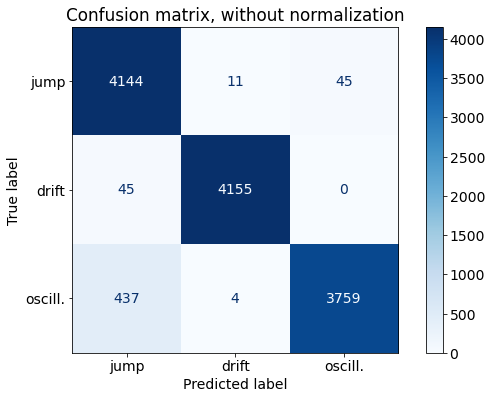

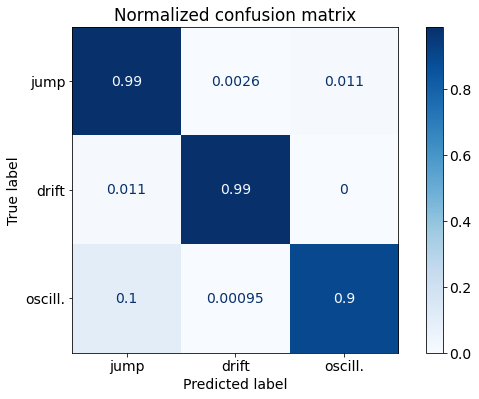

In [24]:
#train the classifier and regressor with selected C
C = 13 #for reproduciability purpose
print('C: ', C)

reg, clf = svm.training_svm(dataIC, control_limit_mv, delta_min,
                wdw_length, scale, delay=True, C=C, block_length=bb_length)

### save models 
#filename = 'svr_Nc_365.sav'
#pickle.dump(reg, open(filename, 'wb'))
#filename = 'svc_Nc_365.sav'
#pickle.dump(clf, open(filename, 'wb'))

For reproduciability purpose, the models that are used in the article have been saved. <br>
Those are available on gitlab (https://gitlab-as.oma.be/SIDC/SILSO_USET/valusun) in the repository **svm_models**. The following commands may be used to load them (with appropriate paths).

In [25]:
reg = pickle.load(open('../svm_models/svr_Nc_27.sav', 'rb'))
clf = pickle.load(open('../svm_models/svc_Nc_27.sav', 'rb'))

## Monitoring and results display

In the previous sections, we adjust the parameters of the CUSUM chart and train the SVM methods on the data. 
We will now apply the method that is fully calibrated to actually monitor those data.

The function ``alerts_info()`` can be used to apply the complete procedure (CUSUM chart plus SVM methods) on a particular series of the panel.
It contains the main following arguments: 
- ``data`` : a standardised series to be monitored
- ``L_plus`` : the value of the positive control limit 
- ``delta`` : the target shift size 
- ``wdw_length`` : the length of the input vector 
- ``clf`` : the trained classifier 
- ``reg`` : the trained regressor 

Six quantities are returned by the function: the positive and negative shapes of the shifts (``form_plus`` and `` form_minus``), sizes of the shifts (``size_plus`` and ``size_minus``) and chart statistics (``C_plus`` and `` C_minus``).  When the series is not in alert, the sizes and forms of the shifts are set to ``NaN``. <br>
The function has also an optional argument, ``cut``, which is set by default to ``2L_plus``. This argument defines the maximal value that the chart statistics are allowed to take, i.e. $|C^+_j|$, $|C^-_j| \leq 2L$. It thus prevents the chart to take too high values and therefore stay in alert for longer periods than the actual deviations of the series. 

Then, diverse functions can be called to display the main features of the monitoring.  
The function ``plot_4panels()`` returns a plot composed of four panels, which shows respectively (1) the unstandardised long-tem error ($\hat \mu_2(i,t)$), (2) the standardised series of data which is analysed, (3) the CUSUM chart statistics ($|C^+|$, $|C^-|$) and (4) the shapes and sizes of the shifts that are predicted by the SVM when the chart is in alert.
The function has the main following arguments: 

- ``data`` : a standardised series to be monitored
- `unstn_data` : the unstardardised series (corresponds here to $\hat \mu_2(i,t)$)
- ``L_plus`` : the value of the positive control limit 
- ``time`` : an array with the time of the observations
- ``form_plus``, ``form_minus`` : the predicted shift forms by SVMs
- ``size_plus``, ``size_minus`` : the predicted shift sizes by SVMs
- ``C_plus``, ``C_minus`` : the CUSUM statistics
- ``name`` : the code name of the series
- ``time_start`` : the starting time value of the figure
- ``time_stop`` : the stoping time value of the figure
- ``x_ticks`` : the locations of the ticks for the x-axis of the figure
- ``labels_ticks`` : the labels of the ticks for the x-axis of the figure
The labels can only be passed if the locations are passed as well.
- ``fig_size`` : the width and heigth of the figure

In the following, the control scheme is applied on all stations of the database.

Percentage of alerts: 41.23


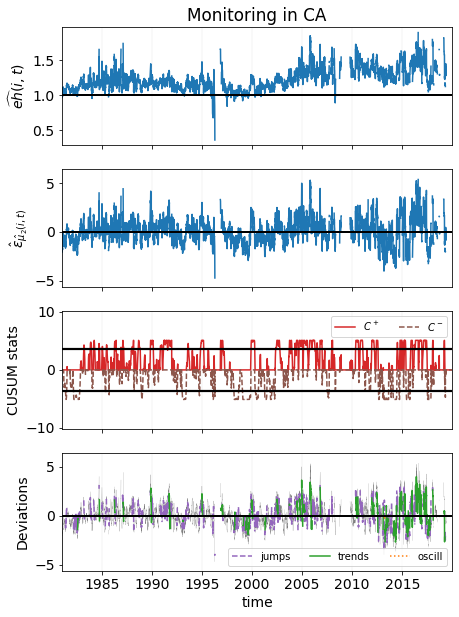

Percentage of alerts: 27.42


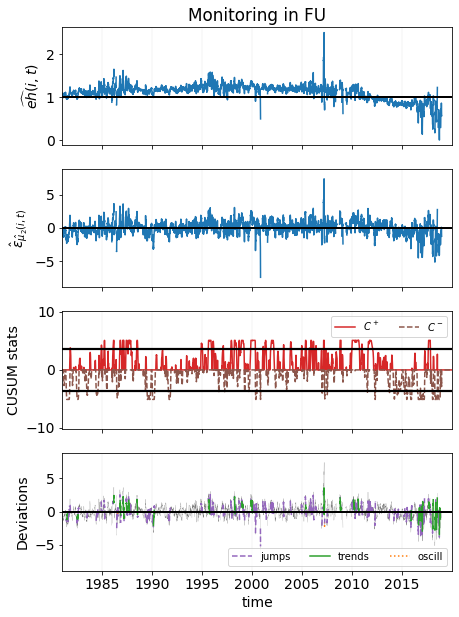

Percentage of alerts: 54.22


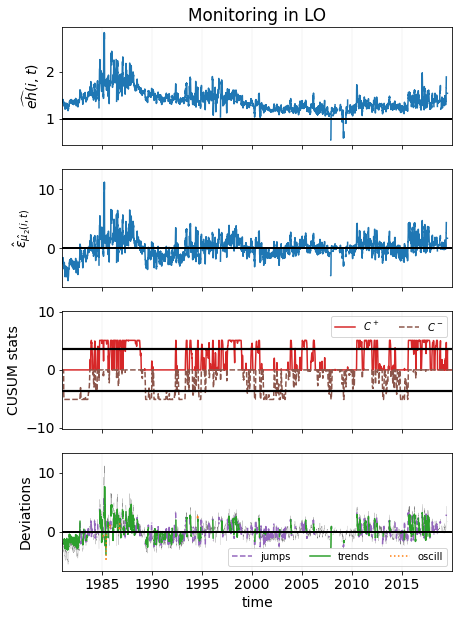

Percentage of alerts: 52.56


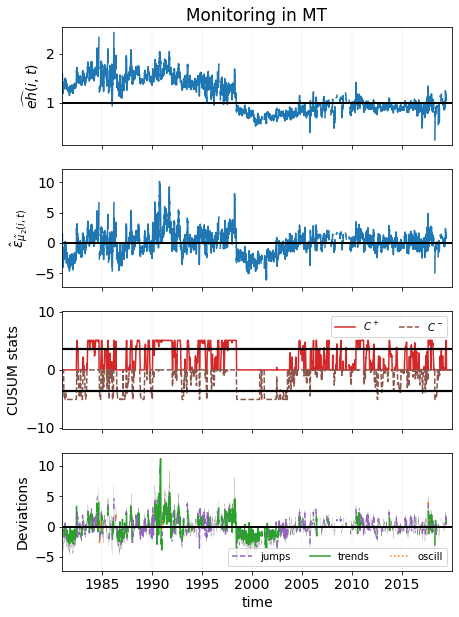

Percentage of alerts: 65.54


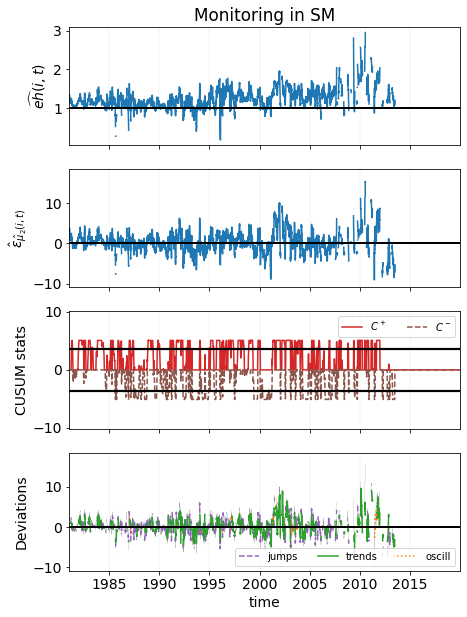

Percentage of alerts: 47.90


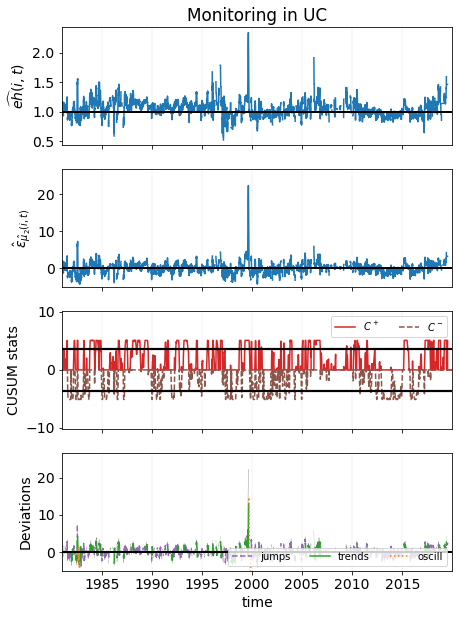

In [23]:
ind = [i for i in range(n_series) if station_names[i] in ['FU','UC','LO','SM','CA','MT']]

for i in ind: 
    data_indv = data[:,i]
    level_indv = mu2[:,i]
    
    [form_plus, form_minus, size_plus, size_minus,
    C_plus, C_minus] = plot.alerts_info(data_indv, control_limit, 
            delta_min, wdw_length, clf, reg)
    
    fig = plot.plot_4panels(data_indv, level_indv, control_limit, time, 
                     form_plus, form_minus, size_plus, size_minus, 
                     C_plus, C_minus, station_names[i], time_start=1981)


<!--bibtex

@ARTICLE{Mathieu2019,
    AUTHOR={{Mathieu}, S. and {von Sachs}, R. and {Delouille}, V. and {Lefevre}, L. and {Ritter}, C.},
    TITLE="{Uncertainty quantification in sunspot counts}",
    JOURNAL={The Astrophysical Journal},
    YEAR={2019}, 
	volume = {886},
	number={1}, 
	pages= {}, 
	doi={https://doi.org/10.3847/1538-4357/ab4990}
}


@article{Kruskal_Wallis,
    author = {{Kruskal}, W. and {Wallis}, W.},
    title ="{Use of ranks in one-criterion variance analysis}",
    journal = {Journal of the American Statistical Association},
    volume = {47},
    number = {260},
    pages = {583-621},
    year = {1952},
    doi = {10.1191/1471082X04st068oa},
    URL = {https://www.jstor.org/stable/2280779}
}

@ARTICLE{Qiu2014,
    author={{Qiu}, P. and {Xiang}, D.},
    title = "{Univariate dynamic screening system: an approach for identifying individuals with irregular longitudinal behaviour}",
    journal = {Technometrics},
	volume = {56},
    number = {2},
    pages = {248-260},
    year = {2014},
	doi = {https://doi.org/10.1080/00401706.2013.822423},
    issn = {0040-1706}
}

@BOOK{Montgomery2005,
   author = {{Montgomery}, D},
   title = "{Introduction to Statistical Quality Control}",
   publisher={Wiley},
   year = {2004},
   edition = {5th}
}

@TechReport{Lloyd1957,
    author={{Lloyd}, S.P. },
    title = "{Least squares quantization in PCM}",
    institution = {Bell Lab},
    year = {1957},
    type = {Technical Report RR-5497},
    number = {5497}
}



@ARTICLE{Cheng2011,
    author={{Cheng}, C-S. and {Chen}, P-W. and {Huang}, K-K. },
    title = "{Estimating the shift size in the process mean with support vector regression and neural network}",
    journal = {Expert Systems with Applications},
    year = {2011},
	volume={38},
	number={8},
	pages={10624-10630},
	doi = {https://doi.org/10.1016/j.eswa.2011.02.121}
}


-->


<!--bibtex

@ARTICLE{Mathieu2019,
    AUTHOR={{Mathieu}, S. and {von Sachs}, R. and {Delouille}, V. and {Lefevre}, L. and {Ritter}, C.},
    TITLE="{Uncertainty quantification in sunspot counts}",
    JOURNAL={The Astrophysical Journal},
    YEAR={2019}, 
	volume = {886},
	number={1}, 
	pages= {}, 
	doi={https://doi.org/10.3847/1538-4357/ab4990}
}


@article{Kruskal_Wallis,
    author = {{Kruskal}, W. and {Wallis}, W.},
    title ="{Use of ranks in one-criterion variance analysis}",
    journal = {Journal of the American Statistical Association},
    volume = {47},
    number = {260},
    pages = {583-621},
    year = {1952},
    doi = {10.1191/1471082X04st068oa},
    URL = {https://www.jstor.org/stable/2280779}
}

@article{Page1961,
author = {{Page}, E. S.},
title ="{Cumulative sum charts}",
journal = {Technometrics},
volume = {3},
number = {1},
pages = {1-9},
year = {1961},
URL = {https://www.jstor.org/stable/1266472}
}
-->


# References

<a id="cite-Mathieu2019"/><sup><a href=#ref-1>[^]</a></sup>Mathieu, S. and von Sachs, R. and Delouille, V. and Lefevre, L. and Ritter, C.. 2019. _Uncertainty quantification in sunspot counts_.

<a id="cite-Kruskal_Wallis"/><sup><a href=#ref-2>[^]</a></sup>Kruskal, W. and Wallis, W.. 1952. _Use of ranks in one-criterion variance analysis_. [URL](https://www.jstor.org/stable/2280779)

<a id="cite-Qiu2014"/><sup><a href=#ref-3>[^]</a></sup>Qiu, P. and Xiang, D.. 2014. _Univariate dynamic screening system: an approach for identifying individuals with irregular longitudinal behaviour_.

<a id="cite-Cheng2011"/><sup><a href=#ref-5>[^]</a></sup>Cheng, C-S. and Chen, P-W. and Huang, K-K. . 2011. _Estimating the shift size in the process mean with support vector regression and neural network_.

<a id="cite-Lloyd1957"/><sup><a href=#ref-6>[^]</a></sup>Lloyd, S.P. . 1957. _Least squares quantization in PCM_.

<a id="cite-Montgomery2005"/><sup><a href=#ref-7>[^]</a></sup>Montgomery, D. 2004. _Introduction to Statistical Quality Control_.

